## Installing Dependencies

In [1]:
!pip install -q datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 31.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 5.5 MB/s eta 0:00:00


In [2]:
!pip install git+https://github.com/huggingface/transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/huggingface/transformers to /tmp/pip-req-build-ewip8m7l
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers /tmp/pip-req-build-ewip8m7l
  Resolved https://github.com/huggingface/transformers to commit 3658488ff77ff8d45101293e749263acf437f4d5
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 85.5 MB/s eta 0:00:00
  Created wheel for transformers: filename=transformers-4.30.0.dev0-py3-none-any.whl size=7120338 sha256=7b0be36ae58162aad283a2e55fd0bd0857c64419aa650c1aa8434a637bf1f3ec
  Stored in directory: /tmp/pip-ephem-wheel-cache-gdfp2m8k/wheels/c0/14/d6/6c9a5582d2ac191ec0a483be151a4495fe1eb2a6706ca49f1b
Successfully built transformers


In [3]:
!pip install -q monai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 38.0 MB/s eta 0:00:00


## Load dataset 

In [4]:
# Mounting google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# Defining root path
import os
os.chdir('/content/drive/MyDrive/sam')
join = os.path.join

In [19]:
import numpy as np
from PIL import Image

# Reading train images into list:
imgs = []
gts = []

for img in sorted(os.listdir('data/train/images')):
    im = Image.open('data/train/images/'+img)
    im = im.resize((256,256))
    imgs.append(im)

for gt in sorted(os.listdir('data/train/masks')):
    im = Image.open('data/train/masks/'+gt)
    im = im.resize((256,256))
    # Changing masks channel into 1 if it is more than single channel
    if(np.array(im).ndim > 2):
        im = im.convert('L')

    gts.append(im)

results = {'imgs':imgs, 'gts':gts}

In [25]:
# Total number of images in the training dataset:
len(sorted(os.listdir('data/train/masks')))

411

In [26]:
# Creating arrow dataset to fed to hunggingface SAM model
from datasets import Dataset as arrow_dataset
from datasets import Image

def create_dataset(images, labels):
    dataset = arrow_dataset.from_dict({"image": images, "label": labels})
    dataset = dataset.cast_column("image", Image())
    dataset = dataset.cast_column("label", Image())

    return dataset

In [27]:
dataset = create_dataset(images = results['imgs'], labels = results['gts'])

In [28]:
# Arrow dataset format
dataset

Dataset({
    features: ['image', 'label'],
    num_rows: 411
})

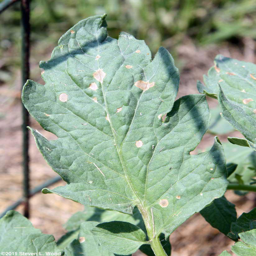

In [29]:
# We can visualize an example:
example = dataset[6]
image = example["image"]
image

input image shape: (256, 256, 3)
mask shape: (256, 256)


(-0.5, 255.5, 255.5, -0.5)

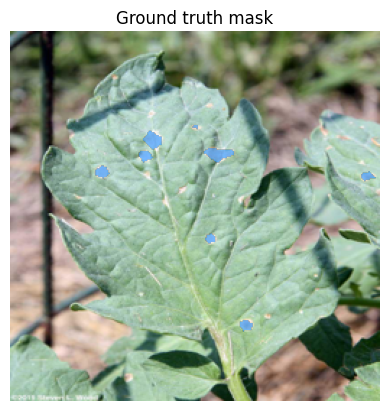

In [30]:
import matplotlib.pyplot as plt

# Method to create a mask on the input image
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

fig, axes = plt.subplots()

axes.imshow(np.array(image))
print('input image shape:',np.array(image).shape)
ground_truth_seg = np.array(example["label"])
print('mask shape:',ground_truth_seg.shape)
show_mask(ground_truth_seg, axes)
axes.title.set_text(f"Ground truth mask")
axes.axis("off")

## Create PyTorch dataset

Model Input consists of:

* pixel values (which is the image prepared for the model)
* a prompt in the form of a bounding box
* a ground truth segmentation mask.

In [31]:
# Method to get a bounding box(prompt) from the groundtruth mask
def get_bounding_box(ground_truth_map):
  # get bounding box from mask
  y_indices, x_indices = np.where(ground_truth_map > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  # add perturbation to bounding box coordinates
  H, W = ground_truth_map.shape
  x_min = max(0, x_min - np.random.randint(0, 20))
  x_max = min(W, x_max + np.random.randint(0, 20))
  y_min = max(0, y_min - np.random.randint(0, 20))
  y_max = min(H, y_max + np.random.randint(0, 20))
  bbox = [x_min, y_min, x_max, y_max]

  return bbox

In [32]:
from torch.utils.data import Dataset as torch_dataset

# Creating a dataset class to handle images with SAM model
class SAMDataset(torch_dataset):
    def __init__(self, dataset, processor):
        self.dataset = dataset
        self.processor = processor

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        image = item["image"]
        ground_truth_mask = np.array(item["label"])

        # get bounding box prompt
        prompt = get_bounding_box(ground_truth_mask)

        # prepare image and prompt for the model
        inputs = self.processor(image, input_boxes=[[prompt]], return_tensors="pt")

        # remove batch dimension which the processor adds by default
        inputs = {k:v.squeeze(0) for k,v in inputs.items()}

        # add ground truth segmentation
        inputs["ground_truth_mask"] = ground_truth_mask

    return inputs

In [33]:
# Calling SAM preprocessor to transform the input images to as per SAM config
from transformers import SamProcessor

processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

In [34]:
train_dataset = SAMDataset(dataset=dataset, processor=processor)

In [35]:
train_dataset.dataset

Dataset({
    features: ['image', 'label'],
    num_rows: 411
})

In [36]:
example = train_dataset[0]
for k,v in example.items():
    print(k,v.shape)

pixel_values torch.Size([3, 1024, 1024])
original_sizes torch.Size([2])
reshaped_input_sizes torch.Size([2])
input_boxes torch.Size([1, 4])
ground_truth_mask (256, 256)


## Create PyTorch DataLoader

Next we define a PyTorch Dataloader, which allows us to get batches from the dataset.



In [37]:
# Creating train dataset loader:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True)

In [38]:
batch = next(iter(train_dataloader))
for k,v in batch.items():
    print(k,v.shape)

pixel_values torch.Size([4, 3, 1024, 1024])
original_sizes torch.Size([4, 2])
reshaped_input_sizes torch.Size([4, 2])
input_boxes torch.Size([4, 1, 4])
ground_truth_mask torch.Size([4, 256, 256])


In [39]:
batch["ground_truth_mask"].shape

torch.Size([4, 256, 256])

## Load the model

In [40]:
from transformers import SamModel 

model = SamModel.from_pretrained("facebook/sam-vit-base")

# make sure we only compute gradients for mask decoder
for name, param in model.named_parameters():
    if name.startswith("vision_encoder") or name.startswith("prompt_encoder"):
        param.requires_grad_(False)

## Train the model

In [41]:
from torch.optim import Adam
import monai

# Note: Hyperparameter tuning could improve performance here
optimizer = Adam(model.mask_decoder.parameters(), lr=1e-5, weight_decay=0)

seg_loss = monai.losses.DiceCELoss(sigmoid=True, squared_pred=True, reduction='mean')

In [42]:
# https://huggingface.co/spaces/evaluate-metric/mean_iou
from tqdm import tqdm
from statistics import mean
import torch
from torch.nn.functional import threshold, normalize

num_epochs = 10
model_save_path = "latest_model"

device = "cuda" if torch.cuda.is_available() else "cpu"
# The loaded checkpoint is already trained for EPOCH: 52  with Mean DiceCE loss: 0.309162582659
# EPOCH: 28 Mean DiceCE loss: 0.29900883036909753
model.load_state_dict(torch.load(model_save_path+'/sam_latest_model.pth',map_location=device))
model.to(device)

SamModel(
  (shared_image_embedding): SamPositionalEmbedding()
  (vision_encoder): SamVisionEncoder(
    (patch_embed): SamPatchEmbeddings(
      (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (layers): ModuleList(
      (0-11): 12 x SamVisionLayer(
        (layer_norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): SamVisionAttention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (layer_norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): SamMLPBlock(
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(in_features=3072, out_features=768, bias=True)
          (act): GELUActivation()
        )
      )
    )
    (neck): SamVisionNeck(
      (conv1): Conv2d(768, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (layer_norm1): SamLayerNorm()
     

In [ ]:
model.train()
for epoch in range(num_epochs):
    epoch_losses = []
    for batch in tqdm(train_dataloader):
        # forward pass
        outputs = model(pixel_values=batch["pixel_values"].to(device),
                      input_boxes=batch["input_boxes"].to(device),
                      multimask_output=False)

        # compute loss
        predicted_masks = outputs.pred_masks.squeeze(1)
        ground_truth_masks = batch["ground_truth_mask"].float().to(device)
        loss = seg_loss(predicted_masks, ground_truth_masks.unsqueeze(1))

        # backward pass (compute gradients of parameters w.r.t. loss)
        optimizer.zero_grad()
        loss.backward()

        # optimize
        optimizer.step()
        epoch_losses.append(loss.item())

    print(f'EPOCH: {epoch+1}')
    print(f'Mean DiceCE loss: {mean(epoch_losses)}')
    # save the model checkpoint
    torch.save(model.state_dict(), join(model_save_path, 'sam_latest_model.pth'))

100%|██████████| 103/103 [03:23<00:00,  1.97s/it]


EPOCH: 1
Mean DiceCE loss: 0.29045578837394714


100%|██████████| 103/103 [03:32<00:00,  2.07s/it]


EPOCH: 2
Mean DiceCE loss: 0.29120908344833596


100%|██████████| 103/103 [03:34<00:00,  2.08s/it]


EPOCH: 3
Mean DiceCE loss: 0.29094882352838236


100%|██████████| 103/103 [03:34<00:00,  2.08s/it]


EPOCH: 4
Mean DiceCE loss: 0.2902809251280664


100%|██████████| 103/103 [03:34<00:00,  2.08s/it]


EPOCH: 5
Mean DiceCE loss: 0.28937493727623836


100%|██████████| 103/103 [03:34<00:00,  2.08s/it]


EPOCH: 6
Mean DiceCE loss: 0.29116688900202226


100%|██████████| 103/103 [03:34<00:00,  2.08s/it]


EPOCH: 7
Mean DiceCE loss: 0.2904646935538181


100%|██████████| 103/103 [03:34<00:00,  2.08s/it]


EPOCH: 8
Mean DiceCE loss: 0.28842115373287386


100%|██████████| 103/103 [03:34<00:00,  2.08s/it]


EPOCH: 9
Mean DiceCE loss: 0.28885999755951963


100%|██████████| 103/103 [03:33<00:00,  2.08s/it]


EPOCH: 10
Mean DiceCE loss: 0.2906257769147169


## Inference

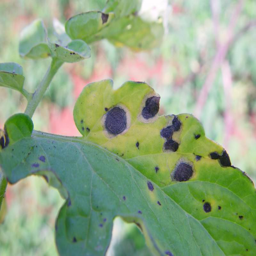

In [43]:
import numpy as np
from PIL import Image

# let's take a random training example
idx = 5

# load image
image = dataset[idx]["image"]
image

In [44]:
# get box prompt based on ground truth segmentation map
ground_truth_mask = np.array(dataset[idx]["label"])
prompt = get_bounding_box(ground_truth_mask)

# prepare image + box prompt for the model
inputs = processor(image, input_boxes=[[prompt]], return_tensors="pt").to(device)
for k,v in inputs.items():
    print(k,v.shape)

pixel_values torch.Size([1, 3, 1024, 1024])
original_sizes torch.Size([1, 2])
reshaped_input_sizes torch.Size([1, 2])
input_boxes torch.Size([1, 1, 4])


In [45]:
model.eval()

# forward pass
with torch.no_grad():
    outputs = model(**inputs, multimask_output=False)

In [46]:
# apply sigmoid
medsam_seg_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))
# convert soft mask to hard mask
medsam_seg_prob = medsam_seg_prob.cpu().numpy().squeeze()
medsam_seg = (medsam_seg_prob > 0.5).astype(np.uint8)

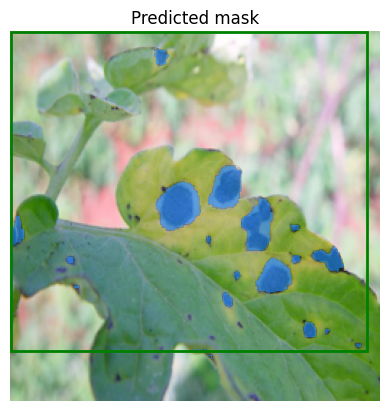

In [47]:
import matplotlib.pyplot as plt

def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    
    ax.imshow(mask_image)

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))  

def show_boxes_on_image(raw_image, boxes):

    fig, axes = plt.subplots()
    axes.imshow(np.array(raw_image))

    show_mask(medsam_seg, axes)
    for box in boxes:
        show_box(box, plt.gca())
    axes.title.set_text(f"Predicted mask")
    axes.axis("off")
    
show_boxes_on_image(image, [prompt])

(-0.5, 255.5, 255.5, -0.5)

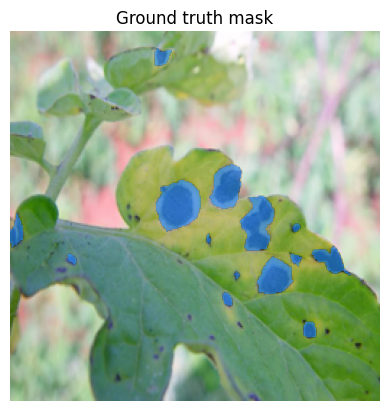

In [48]:
fig, axes = plt.subplots()

axes.imshow(np.array(image))l
show_mask(ground_truth_mask, axes)
axes.title.set_text(f"Ground truth mask")
axes.axis("off")

### **Model Evaluation**

In [21]:
from PIL import Image
import numpy as np
from torch.utils.data import DataLoader

imgs = []
gts = []

for img in sorted(os.listdir('data/test/images')):
    im = Image.open('data/test/images/'+img)
    im = im.resize((256,256))
    imgs.append(im)
    # im.show()

for gt in sorted(os.listdir('data/test/masks')):
    im = Image.open('data/test/masks/'+gt)
    im = im.resize((256,256))
    if(np.array(im).ndim > 2):
        im = im.convert('L')

    gts.append(im)
    # im.show()

test_results = {'imgs':imgs, 'gts':gts}

In [49]:
test_dataset = create_dataset(images = test_results['imgs'], labels = test_results['gts'])
test_dataset = SAMDataset(dataset=test_dataset, processor=processor)
test_dataloader = DataLoader(test_dataset, batch_size=4, shuffle=True)

In [50]:
import torch

def calculate_iou(predicted_mask, ground_truth_mask):
    # Threshold predicted mask to binary values
    predicted_mask = (predicted_mask > 0.5).float()
    ground_truth_mask = ground_truth_mask.float() 

    # Calculate intersection and union
    intersection = torch.sum(predicted_mask * ground_truth_mask)
    union = torch.sum(predicted_mask) + torch.sum(ground_truth_mask) - intersection

    # Calculate IoU
    iou = intersection / (union + 1e-7)  # Add epsilon to avoid division by zero

    return iou

In [90]:
# Create an iterator from the DataLoader
data_iter = iter(test_dataloader)

# Randomly sample one item
sample = next(data_iter)

# Access the input data and labels
image = sample['pixel_values'][0].unsqueeze(0)
mask = sample['ground_truth_mask'][0].unsqueeze(0)
box = sample['input_boxes'][0].unsqueeze(0)

model.eval()
# forward pass
with torch.no_grad():
    pred = model(pixel_values=image.to(device),
                      input_boxes=box.to(device),
                      multimask_output=False)

In [91]:
pred = pred.pred_masks

In [92]:
mask = torch.tensor(np.where(mask>0,1,0))

In [93]:
iou = calculate_iou(pred[0].squeeze(0), mask.to(device))
iou

tensor(0.8163, device='cuda:0')

In [133]:
miou = 0
model.eval()
for batch in (test_dataloader):
    batch_iou = 0
    for j in tqdm(range(batch['pixel_values'].shape[0])):
        # Access the input data and labels
        image = batch['pixel_values'][j].unsqueeze(0)
        mask = batch['ground_truth_mask'][j].unsqueeze(0)
        box = batch['input_boxes'][j].unsqueeze(0)

        # forward pass
        with torch.no_grad():

            pred = model(pixel_values=image.to(device),
                                input_boxes=box.to(device),
                                multimask_output=False)
            pred = pred.pred_masks
            mask = torch.tensor(np.where(mask>0,1,0))
            iou = calculate_iou(pred[0].squeeze(0), mask.to(device))
            batch_iou += iou.item()

    miou += (batch_iou/batch['pixel_values'].shape[0])

100%|██████████| 1/1 [00:00<00:00,  2.57it/s]


In [135]:
print("Avg_IoU:",round((miou/len(test_dataloader)),2))

Avg_IoU: 0.59
